In [62]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [63]:
from dataclasses import dataclass
import os
from tempfile import TemporaryDirectory
from typing import List, Any, Dict

from shapely.geometry import box, mapping
!pip install rasterio
import rasterio
from rasterio.warp import reproject, Resampling
!pip install pyproj
import pyproj
from osgeo import gdal

!pip install pystac_client
from pystac_client import Client
!pip install planetary_computer
import planetary_computer as pc

In [64]:
#Importing Files from Google Drive
#Not Universal. Must have uncompressed files uploaded in Google Drive Folder
#Files can be uncompressed using tarfile module (tar.extractall())
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
#Define whatever folder your uncompressed files are in (after MyDrive)
DATA_PATH = Path(r'/content/drive/MyDrive/Colab_Files/Floodwater_STAC_Overflow/data')

In [ ]:
train_metadata = pd.read_csv(
    DATA_PATH / "flood-training-metadata.csv" , parse_dates=["scene_start"]
)

In [ ]:
initial_no_of_images = len(train_metadata)
initial_no_of_images

1084

In [ ]:
train_metadata.head()

,image_id,chip_id,flood_id,polarization,location,scene_start
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15


In [ ]:
!pip install pandas_path
from pandas_path import path #path specially for pandas

In [ ]:
#Stac_api for planetary computer for Nasadem and jrc datasets
STAC_API = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = Client.open(STAC_API)

In [ ]:
#Gather chip paths
TRAINING_DATA_DIR = DATA_PATH / 'train_features'
chip_paths = []
for file_name in os.listdir(TRAINING_DATA_DIR):
    if file_name.endswith("_vv.tif"):
        chip_paths.append(os.path.join(TRAINING_DATA_DIR, file_name))
print(f"{len(chip_paths)} chips found.")

542 chips found.


In [ ]:
#Define a ChipInfo dataclass to encapsulate the required data for the target chip. 
#This includes geospatial information that will be used to coregister the incoming jrc-gsw and nasadem data.
@dataclass
class ChipInfo:
    """
    Holds information about a training chip, including geospatial info for coregistration
    """

    path: str
    prefix: str
    crs: Any
    shape: List[int]
    transform: List[float]
    bounds: rasterio.coords.BoundingBox
    footprint: Dict[str, Any]


def get_footprint(bounds, crs):
    """Gets a GeoJSON footprint (in epsg:4326) from rasterio bounds and CRS"""
    transformer = pyproj.Transformer.from_crs(crs, "epsg:4326", always_xy=True)
    minx, miny = transformer.transform(bounds.left, bounds.bottom)
    maxx, maxy = transformer.transform(bounds.right, bounds.top)
    return mapping(box(minx, miny, maxx, maxy))


def get_chip_info(chip_path):
    """Gets chip info from a GeoTIFF file"""
    with rasterio.open(chip_path) as ds:
        chip_crs = ds.crs
        chip_shape = ds.shape
        chip_transform = ds.transform
        chip_bounds = ds.bounds

    # Use the first part of the chip filename as a prefix
    prefix = os.path.basename(chip_path).split("_")[0]

    return ChipInfo(
        path=chip_path,
        prefix=prefix,
        crs=chip_crs,
        shape=chip_shape,
        transform=chip_transform,
        bounds=chip_bounds,
        footprint=get_footprint(chip_bounds, chip_crs),
    )

In [ ]:
#This method reprojects coregisters raster data to the bounds, CRS and resolution described by the ChipInfo.
def reproject_to_chip(
    chip_info, input_path, output_path, resampling=Resampling.nearest
):
    """
    Reproject a raster at input_path to chip_info, saving to output_path.

    Use Resampling.nearest for classification rasters. Otherwise use something
    like Resampling.bilinear for continuous data.
    """
    with rasterio.open(input_path) as src:
        kwargs = src.meta.copy()
        kwargs.update(
            {
                "crs": chip_info.crs,
                "transform": chip_info.transform,
                "width": chip_info.shape[1],
                "height": chip_info.shape[0],
                "driver": "GTiff",
            }
        )

        with rasterio.open(output_path, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=chip_info.transform,
                    dst_crs=chip_info.crs,
                    resampling=Resampling.nearest,
                )

In [ ]:
#Something complicated but basically creates a bunch of authenticated hyperlinks to the required Elevation and JRC Data in Planetary Computer.
def write_vrt(items, asset_key, dest_path):
    """Write a VRT with hrefs extracted from a list of items for a specific asset."""
    hrefs = [pc.sign(item.assets[asset_key].href) for item in items]
    vsi_hrefs = [f"/vsicurl/{href}" for href in hrefs]
    gdal.BuildVRT(dest_path, vsi_hrefs).FlushCache()

In [ ]:
#Creates a new chip with required elevation/jrc data and saves it in same directory as old
def create_chip_aux_file(
    chip_info, collection_id, asset_key, file_name, resampling=Resampling.nearest
):
    """
    Write an auxiliary chip file.

    The auxiliary chip file includes chip_info for the Collection and Asset, and is
    saved in the same directory as the original chip with the given file_name.
    """
    output_path = os.path.join(
        os.path.dirname(chip_info.path), f"{chip_info.prefix}_{file_name}"
    )
    search = catalog.search(collections=[collection_id], intersects=chip_info.footprint)
    items = list(search.get_items())
    with TemporaryDirectory() as tmp_dir:
        vrt_path = os.path.join(tmp_dir, "source.vrt")
        write_vrt(items, asset_key, vrt_path)
        reproject_to_chip(chip_info, vrt_path, output_path, resampling=resampling)
    return output_path

In [ ]:
# Configurate the auxiliary input files that we will generate
# Define a set of parameters to pass into create_chip_aux_file
aux_file_params = [
    ("nasadem", "elevation", "nasadem.tif", Resampling.bilinear),
    ("jrc-gsw", "extent", "jrc-gsw-extent.tif", Resampling.nearest),
    ("jrc-gsw", "occurrence", "jrc-gsw-occurrence.tif", Resampling.nearest),
    ("jrc-gsw", "recurrence", "jrc-gsw-recurrence.tif", Resampling.nearest),
    ("jrc-gsw", "seasonality", "jrc-gsw-seasonality.tif", Resampling.nearest),
    ("jrc-gsw", "transitions", "jrc-gsw-transitions.tif", Resampling.nearest),
    ("jrc-gsw", "change", "jrc-gsw-change.tif", Resampling.nearest),
]

In [ ]:
# Iterate over the chips and generate all aux input files.
count = len(chip_paths)
# for i, chip_path in enumerate(chip_paths):
#     print(f"({i+1} of {count}) {chip_path}")
#     chip_info = get_chip_info(chip_path)
#     for collection_id, asset_key, file_name, resampling_method in aux_file_params:
#         print(f"  ... Creating chip data for {collection_id} {asset_key}")
#         create_chip_aux_file(
#             chip_info, collection_id, asset_key, file_name, resampling=resampling_method
#         )

In [ ]:
#Adding Image Paths (.tif) for all the New Elevation/JRC Features to train_matadata
#Literally adds a new image as in awc00_vh.tif.....awc_nasadem.tif as separate rows
extra_images_list = ['jrc-gsw-change', 
                     'jrc-gsw-extent', 
                     'jrc-gsw-occurrence', 
                     'jrc-gsw-recurrence', 
                     'jrc-gsw-seasonality', 
                     'jrc-gsw-transitions', 
                     'nasadem']

# Iterating over Meta Dataset to add new images in each chip (Elevation and JRC)
for chip in train_metadata['chip_id'].unique():
  chip_id = chip
  flood_id = train_metadata[train_metadata.chip_id == chip].flood_id.iloc[0]
  location = train_metadata[train_metadata.chip_id == chip].location.iloc[0]
  scene_start = train_metadata[train_metadata.chip_id == chip].scene_start.iloc[0]
  for img_name in extra_images_list:
    image_id = chip+"_"+img_name
    polarization = img_name
    add_dict = {'image_id' : image_id, 'chip_id' : chip_id, 'flood_id': flood_id, 'polarization': polarization, 'location' : location, 'scene_start' : scene_start}
    train_metadata = train_metadata.append(add_dict, ignore_index=True)

train_metadata = train_metadata.sort_values(by = ['image_id'])

In [ ]:
train_metadata.head()

,image_id,chip_id,flood_id,polarization,location,scene_start
1084,awc00_jrc-gsw-change,awc00,awc,jrc-gsw-change,Bolivia,2018-02-15
1085,awc00_jrc-gsw-extent,awc00,awc,jrc-gsw-extent,Bolivia,2018-02-15
1086,awc00_jrc-gsw-occurrence,awc00,awc,jrc-gsw-occurrence,Bolivia,2018-02-15
1087,awc00_jrc-gsw-recurrence,awc00,awc,jrc-gsw-recurrence,Bolivia,2018-02-15
1088,awc00_jrc-gsw-seasonality,awc00,awc,jrc-gsw-seasonality,Bolivia,2018-02-15


In [ ]:
final_no_of_images = len(train_metadata)
final_no_of_images

4878

In [ ]:
#Adding Feature and Label Paths
#Defining path to train features (including nasadem & jrc)
train_metadata["feature_path"] = (
    str(DATA_PATH / "train_features")
    / train_metadata.image_id.path.with_suffix(".tif").path
)

In [ ]:
#Defining path to train labels(semantic)
train_metadata["label_path"] = (
    str(DATA_PATH / "train_labels")
    / train_metadata.chip_id.path.with_suffix(".tif").path
)

In [ ]:
train_metadata.feature_path[0]

'/content/drive/MyDrive/Colab_Files/Floodwater_STAC_Overflow/data/train_features/awc00_vh.tif'

In [ ]:
# Examine an arbitrary image
image_path = train_metadata.feature_path[0]

In [ ]:
#Opening .tif file with rasterio
with rasterio.open(image_path) as img:
    metadata = img.meta
    bounds = img.bounds
    data = img.read(1)  # read a single band

In [ ]:
metadata

{'count': 1,
 'crs': CRS.from_epsg(32720),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 512,
 'nodata': 0.0,
 'transform': Affine(10.0, 0.0, 314030.0,
       0.0, -10.0, 8585890.0),
 'width': 512}

In [ ]:
bounds

BoundingBox(left=314030.0, bottom=8580770.0, right=319150.0, top=8585890.0)

In [ ]:
data.max()

0.0

In [ ]:
#Setting initial min and max values to data of first chip (awc00)
min_list = []
max_list = []

# Min & Max of awc00 vv and vh
for i in range(2):
  image_path = train_metadata.feature_path[i]
  with rasterio.open(image_path) as img:
    data = img.read(1)
  min_list.append(data.min())
  max_list.append(data.max())

# Min & Max of awc00 jrc and nasadem 
for i in range(7):
  image_path = train_metadata.feature_path[1084+i]
  with rasterio.open(image_path) as img:
    data = img.read(1)
  min_list.append(data.min())
  max_list.append(data.max())

print(min_list)
print(max_list) 


[-56.406128, -46.65592, 0, 0, 0, 0, 0, 0, 142]
[0.0, 0.0, 253, 1, 1, 54, 0, 10, 170]


In [ ]:
#Function to give min and max values of a given .img file
def min_max_raster(train_metadata, j):
  image_path = train_metadata.feature_path[j]
  with rasterio.open(image_path) as img:
    data = img.read(1)
  return [data.min(), data.max()]


In [ ]:
import multiprocessing as mp #For parallelization

In [ ]:
#Iterating over whole set to final min and max values (Parallelization)

# Obtained Values are given below as it takes 15 mins to iterate
min_list = [-79.141174, -70.6078, 0, 0, 0, 0, 0, 0, -64]
max_list = [27.942997, 34.4235, 255, 255, 255, 255, 255, 10, 2091]

#Iterating over vv and vh paths
# for i in range(2):
#   pool = mp.Pool(mp.cpu_count())
#   results = np.array([pool.apply(min_max_raster, args=(train_metadata, j)) for j in range(i, initial_no_of_images, 2)])
#   pool.close()    
#   min_list[i] = results.min()
#   max_list[i] = results.max()

# # # Iterating over JRC and NASADEM paths
# for i in range(7):
#   pool = mp.Pool(mp.cpu_count())
#   results = np.array([pool.apply(min_max_raster, args=(train_metadata, j)) for j in range(initial_no_of_images+i, final_no_of_images, 7)])
#   pool.close()    
#   min_list[i+2] = results.min()
#   max_list[i+2] = results.max()

print(min_list)
print(max_list)

[-79.141174, -70.6078, 0, 0, 0, 0, 0, 0, -64]
[27.942997, 34.4235, 255, 255, 255, 255, 255, 10, 2091]


In [ ]:
#Iterating over whole set to fin min and max values (Non-paralellized)
#Not to Be Used. Above parallel one is much faster

#Iterating over vv and vh paths
# for i in range(2):
#   for j in range(i, initial_no_of_images, 2):
#     image_path = train_metadata.feature_path[j]
#     with rasterio.open(image_path) as img:
#       data = img.read(1)
#     if data.min()<min_list[i]:
#       min_list[i] = data.min()
#     if data.max()>max_list[i]:
#       max_list[i] = data.max()
#   print("min ",i," = ", min_list[i])
#   print("max ",i," = ", max_list[i])

# # Iterating over JRC and NASADEM paths
# for i in range(6):
#   for j in range(initial_no_of_images+i, final_no_of_images, 7):
#     image_path = train_metadata.feature_path[j]
#     with rasterio.open(image_path) as img:
#       data = img.read(1)
#     if data.min()<min_list[2+i]:
#       min_list[2+i] = data.min()
#     if data.max()>max_list[2+i]:
#       max_list[2+i] = data.max()
#   print("min ",i+2," = ", min_list[i+2])
#   print("max ",i+2," = ", max_list[i+2])



In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# Helper functions for visualizing Sentinel-1 images
def scale_img(matrix):
    """
    Returns a scaled (H, W, D) image that is visually inspectable.
    Image is linearly scaled between min_ and max_value, by channel.

    Args:
        matrix (np.array): (H, W, D) image to be scaled

    Returns:
        np.array: Image (H, W, 3) ready for visualization
    """
    # Set min/max values
    min_values = np.array([-23, -28, 0.2])
    max_values = np.array([0, -5, 1])

    # Reshape matrix
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)

    # Scale by min/max
    matrix = (matrix - min_values[None, :]) / (
        max_values[None, :] - min_values[None, :]
    )
    matrix = np.reshape(matrix, [w, h, d])

    # Limit values to 0/1 interval
    return matrix.clip(0, 1)


def create_false_color_composite(path_vv, path_vh):
    """
    Returns a S1 false color composite for visualization.

    Args:
        path_vv (str): path to the VV band
        path_vh (str): path to the VH band

    Returns:
        np.array: image (H, W, 3) ready for visualization
    """
    # Read VV/VH bands
    with rasterio.open(path_vv) as vv:
        vv_img = vv.read(1)
    with rasterio.open(path_vh) as vh:
        vh_img = vh.read(1)

    # Stack arrays along the last dimension
    s1_img = np.stack((vv_img, vh_img), axis=-1)

    # Create false color composite
    img = np.zeros((512, 512, 3), dtype=np.float32)
    img[:, :, :2] = s1_img.copy()
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]

    return scale_img(img)


def display_random_chip(random_state):
    """
    Plots a 3-channel representation of VV/VH polarizations as a single chip (image 1).
    Overlays a chip's corresponding water label (image 2).

    Args:
        random_state (int): random seed used to select a chip

    Returns:
        plot.show(): chip and labels plotted with pyplot
    """
    f, ax = plt.subplots(1, 2, figsize=(9, 9))

    # Select a random chip from train_metadata
    random_chip = train_metadata.chip_id.sample(random_state=random_state).values[0]
    chip_df = train_metadata[train_metadata.chip_id == random_chip]

    # Extract paths to image files
    vv_path = chip_df[chip_df.polarization == "vv"].feature_path.values[0]
    vh_path = chip_df[chip_df.polarization == "vh"].feature_path.values[0]
    label_path = chip_df.label_path.values[0]

    # Create false color composite
    s1_img = create_false_color_composite(vv_path, vh_path)

    # Visualize features
    ax[0].imshow(s1_img)
    ax[0].set_title("S1 Chip", fontsize=14)

    # Load water mask
    with rasterio.open(label_path) as lp:
        lp_img = lp.read(1)

    # Mask missing data and 0s for visualization
    label = np.ma.masked_where((lp_img == 0) | (lp_img == 255), lp_img)

    # Visualize water label
    ax[1].imshow(s1_img)
    ax[1].imshow(label, cmap="cool", alpha=1)
    ax[1].set_title("S1 Chip with Water Label", fontsize=14)

    plt.tight_layout(pad=5)
    plt.show()

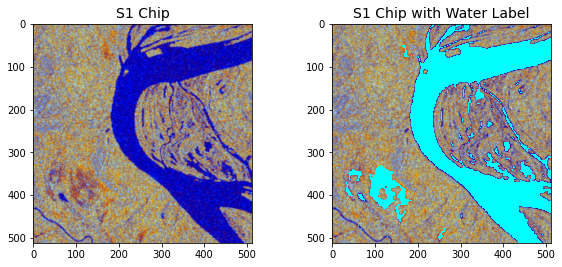

In [ ]:
display_random_chip(211)


In [ ]:
import random

In [66]:
random.seed(9)  # set a seed (2) for reproducibility

# Sample 3 random floods for validation set
flood_ids = train_metadata.flood_id.unique().tolist()
val_flood_ids = random.sample(flood_ids, 3)
val_flood_ids

['pxs', 'qxb', 'jja']

In [ ]:
#Val and train are just subsets of train_metadata
val = train_metadata[train_metadata.flood_id.isin(val_flood_ids)]
train = train_metadata[~train_metadata.flood_id.isin(val_flood_ids)]

In [ ]:
val.head()

,image_id,chip_id,flood_id,polarization,location,scene_start,feature_path,label_path
1084,awc00_jrc-gsw-change,awc00,awc,jrc-gsw-change,Bolivia,2018-02-15,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...
1085,awc00_jrc-gsw-extent,awc00,awc,jrc-gsw-extent,Bolivia,2018-02-15,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...
1086,awc00_jrc-gsw-occurrence,awc00,awc,jrc-gsw-occurrence,Bolivia,2018-02-15,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...
1087,awc00_jrc-gsw-recurrence,awc00,awc,jrc-gsw-recurrence,Bolivia,2018-02-15,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...
1088,awc00_jrc-gsw-seasonality,awc00,awc,jrc-gsw-seasonality,Bolivia,2018-02-15,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...


In [67]:
# Helper function for pivoting out paths by chip
def get_paths_by_chip(image_level_df):
    """
    Returns a chip-level dataframe with pivoted columns
    for vv_path and vh_path.

    Args:
        image_level_df (pd.DataFrame): image-level dataframe

    Returns:
        chip_level_df (pd.DataFrame): chip-level dataframe
    """
    paths = []
    for chip, group in image_level_df.groupby("chip_id"):
        vv_path = group[group.polarization == "vv"]["feature_path"].values[0]
        vh_path = group[group.polarization == "vh"]["feature_path"].values[0]
        jrc1_path = group[group.polarization == "jrc-gsw-change"]["feature_path"].values[0]
        jrc2_path = group[group.polarization == "jrc-gsw-extent"]["feature_path"].values[0]
        jrc3_path = group[group.polarization == "jrc-gsw-occurrence"]["feature_path"].values[0]
        jrc4_path = group[group.polarization == "jrc-gsw-recurrence"]["feature_path"].values[0]
        jrc5_path = group[group.polarization == "jrc-gsw-seasonality"]["feature_path"].values[0]
        jrc6_path = group[group.polarization == "jrc-gsw-transitions"]["feature_path"].values[0]
        nasadem_path = group[group.polarization == "nasadem"]["feature_path"].values[0]
        paths.append([chip, vv_path, vh_path, jrc1_path, jrc2_path, jrc3_path, jrc4_path, jrc5_path, jrc6_path, nasadem_path])
    return pd.DataFrame(paths, columns=["chip_id", "vv_path", "vh_path", "jrc1_path", "jrc2_path", "jrc3_path", "jrc4_path", "jrc5_path", "jrc6_path", "nasadem_path"])

In [ ]:
# Separate features from labels
val_x = get_paths_by_chip(val)
val_y = val[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

train_x = get_paths_by_chip(train)
train_y = train[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

In [68]:
train_x.head()

,chip_id,vv_path,vh_path,jrc1_path,jrc2_path,jrc3_path,jrc4_path,jrc5_path,jrc6_path,nasadem_path
0,coz00,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...
1,coz01,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...
2,coz02,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...
3,coz03,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...
4,coz04,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...,/content/drive/MyDrive/Colab_Files/Floodwater_...


In [ ]:
import torch


In [73]:
# For Removing a Feature, do the Following: 
# Remove it's path definer in __getitem__
# Remove its min-max values from normalization
# Change range value in normalization for loop
# Remove paths from x_arr numpy stac
# and change no of input channels in _prepare_model in FloodModel class
class FloodDataset(torch.utils.data.Dataset):
    """Reads in images, transforms pixel values, and serves a
    dictionary containing chip ids, image tensors, and
    label masks (where available).
    """

    def __init__(self, x_paths, y_paths=None, transforms=None):
        self.data = x_paths
        self.label = y_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Loads a 2-channel image from a chip-level dataframe
        img = self.data.loc[idx]
        with rasterio.open(img.vv_path) as vv:
            vv_path = vv.read(1)
        with rasterio.open(img.vh_path) as vh:
            vh_path = vh.read(1)
        # with rasterio.open(img.jrc1_path) as jrc1:
        #     jrc1_path = jrc1.read(1)
        # with rasterio.open(img.jrc2_path) as jrc2:
        #     jrc2_path = jrc2.read(1)
        # with rasterio.open(img.jrc3_path) as jrc3:
        #     jrc3_path = jrc3.read(1)
        # with rasterio.open(img.jrc4_path) as jrc4:
        #     jrc4_path = jrc4.read(1)
        # with rasterio.open(img.jrc5_path) as jrc5:
        #     jrc5_path = jrc5.read(1)
        # with rasterio.open(img.jrc6_path) as jrc6:
        #     jrc6_path = jrc6.read(1)
        with rasterio.open(img.nasadem_path) as nasadem:
            nasadem_path = nasadem.read(1)
        x_arr = np.stack([vv_path, vh_path, 
                          # jrc1_path, jrc2_path, jrc3_path, jrc4_path, jrc5_path, jrc6_path, 
                          nasadem_path], axis=-1)

        # Min-max normalization
        min_list = [-79.141174, -70.6078, 
                    # 0, 0, 0, 0, 0, 0, 
                    -64]
        max_list = [27.942997, 34.4235, 
                    # 255, 255, 255, 255, 255, 10, 
                    2091]
        # x_arr = np.clip(x_arr, min_norm, max_norm) #Delete Later

        for i in range(3):
          x_arr[:,:,i] = (x_arr[:,:,i] - min_list[i]) / (max_list[i] - min_list[i])

        # Apply data augmentations, if provided
        if self.transforms:
            x_arr = self.transforms(image=x_arr)["image"]
        x_arr = np.transpose(x_arr, [2, 0, 1])

        # Prepare sample dictionary
        sample = {"chip_id": img.chip_id, "chip": x_arr}

        # Load label if available - training only
        if self.label is not None:
            label_path = self.label.loc[idx].label_path
            with rasterio.open(label_path) as lp:
                y_arr = lp.read(1)
            # Apply same data augmentations to label
            if self.transforms:
                y_arr = self.transforms(image=y_arr)["image"]
            sample["label"] = y_arr

        return sample

In [ ]:
import albumentations


In [ ]:
# These transformations will be passed to our model class
#Data Augmentation
training_transformations = albumentations.Compose(
    [
        albumentations.RandomCrop(256, 256),
        albumentations.RandomRotate90(),
        albumentations.HorizontalFlip(),
        albumentations.VerticalFlip(),
    ]
)

In [ ]:
#Training Data Eval
class XEDiceLoss(torch.nn.Module):
    """
    Computes (0.5 * CrossEntropyLoss) + (0.5 * DiceLoss).
    """

    def __init__(self):
        super().__init__()
        self.xe = torch.nn.CrossEntropyLoss(reduction="none")

    def forward(self, pred, true):
        valid_pixel_mask = true.ne(255)  # valid pixel mask

        # Cross-entropy loss
        temp_true = torch.where((true == 255), 0, true)  # cast 255 to 0 temporarily
        xe_loss = self.xe(pred, temp_true)
        xe_loss = xe_loss.masked_select(valid_pixel_mask).mean()

        # Dice loss
        pred = torch.softmax(pred, dim=1)[:, 1]
        pred = pred.masked_select(valid_pixel_mask)
        true = true.masked_select(valid_pixel_mask)
        dice_loss = 1 - (2.0 * torch.sum(pred * true)) / (torch.sum(pred + true) + 1e-7)

        return (0.5 * xe_loss) + (0.5 * dice_loss)


In [ ]:
#Val Eval
def intersection_and_union(pred, true):
    """
    Calculates intersection and union for a batch of images.

    Args:
        pred (torch.Tensor): a tensor of predictions
        true (torc.Tensor): a tensor of labels

    Returns:
        intersection (int): total intersection of pixels
        union (int): total union of pixels
    """
    valid_pixel_mask = true.ne(255)  # valid pixel mask
    true = true.masked_select(valid_pixel_mask).to("cpu")
    pred = pred.masked_select(valid_pixel_mask).to("cpu")

    # Intersection and union totals
    intersection = np.logical_and(true, pred)
    union = np.logical_or(true, pred)
    return intersection.sum(), union.sum()

In [ ]:
!pip install pytorch_lightning

     |████████████████████████████████| 923 kB 4.1 MB/s 
     |████████████████████████████████| 636 kB 36.7 MB/s 
     |████████████████████████████████| 119 kB 51.6 MB/s 
     |████████████████████████████████| 282 kB 52.3 MB/s 
     |████████████████████████████████| 829 kB 33.2 MB/s 
     |████████████████████████████████| 1.3 MB 39.4 MB/s 
     |████████████████████████████████| 294 kB 50.1 MB/s 
     |████████████████████████████████| 142 kB 45.9 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=cc59fcc2015145c30486cb42e38d6e8b5ec5e633781cc76eff6ac8702417090c
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0

In [ ]:
!pip install segmentation_models_pytorch

     |████████████████████████████████| 87 kB 3.1 MB/s 
     |████████████████████████████████| 376 kB 25.3 MB/s 
     |████████████████████████████████| 58 kB 6.5 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=b44744427d6c951820fe3d11f5a867fd6088fb4dee53d69e9e2baddba5ca4673
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=0b574640afd12fa449465079082e1fa4e998757c86828f72aa754205cf976738
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [70]:
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
class FloodModel(pl.LightningModule):
    def __init__(self, hparams):
        super(FloodModel, self).__init__()
        self.hparams.update(hparams)
        self.save_hyperparameters()
        self.backbone = self.hparams.get("backbone", "resnet34")
        self.weights = self.hparams.get("weights", "imagenet")
        self.learning_rate = self.hparams.get("lr", 1e-3)
        self.max_epochs = self.hparams.get("max_epochs", 1000)
        self.min_epochs = self.hparams.get("min_epochs", 6)
        self.patience = self.hparams.get("patience", 4)
        self.num_workers = self.hparams.get("num_workers", 2)
        self.batch_size = self.hparams.get("batch_size", 32)
        self.x_train = self.hparams.get("x_train")
        self.y_train = self.hparams.get("y_train")
        self.x_val = self.hparams.get("x_val")
        self.y_val = self.hparams.get("y_val")
        self.output_path = self.hparams.get("output_path", "model-outputs")
        self.gpu = self.hparams.get("gpu", False)
        self.transform = training_transformations

        # Where final model will be saved
        self.output_path = Path.cwd() / self.output_path
        self.output_path.mkdir(exist_ok=True)

        # Track validation IOU globally (reset each epoch)
        self.intersection = 0
        self.union = 0

        # Instantiate datasets, model, and trainer params
        self.train_dataset = FloodDataset(
            self.x_train, self.y_train, transforms=self.transform
        )
        self.val_dataset = FloodDataset(self.x_val, self.y_val, transforms=None)
        self.model = self._prepare_model()
        self.trainer_params = self._get_trainer_params()

    ## Required LightningModule methods ##

    def forward(self, image):
        # Forward pass
        return self.model(image)

    def training_step(self, batch, batch_idx):
        # Switch on training mode
        self.model.train()
        torch.set_grad_enabled(True)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass
        preds = self.forward(x)

        # Calculate training loss
        criterion = XEDiceLoss()
        xe_dice_loss = criterion(preds, y)

        # Log batch xe_dice_loss
        self.log(
            "xe_dice_loss",
            xe_dice_loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        return xe_dice_loss

    def validation_step(self, batch, batch_idx):
        # Switch on validation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass & softmax
        preds = self.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1

        # Calculate validation IOU (global)
        intersection, union = intersection_and_union(preds, y)
        self.intersection += intersection
        self.union += union

        # Log batch IOU
        batch_iou = intersection / union
        self.log(
            "iou", batch_iou, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return batch_iou

    def train_dataloader(self):
        # DataLoader class for training
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
        )

    def val_dataloader(self):
        # DataLoader class for validation
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=0,
            shuffle=False,
            pin_memory=True,
        )

    def configure_optimizers(self):
        # Define optimizer
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

        # Define scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", factor=0.5, patience=self.patience
        )
        scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "val_loss",
        }  # logged value to monitor
        return [optimizer], [scheduler]

    def validation_epoch_end(self, outputs):
        # Calculate IOU at end of epoch
        epoch_iou = self.intersection / self.union

        # Reset metrics before next epoch
        self.intersection = 0
        self.union = 0

        # Log epoch validation IOU
        self.log("val_loss", epoch_iou, on_epoch=True, prog_bar=True, logger=True)
        return epoch_iou

    ## Convenience Methods ##

    def _prepare_model(self):
        unet_model = smp.Unet(
            encoder_name=self.backbone,
            encoder_weights=self.weights,
            in_channels=3, #No. of INPUT CHANNELS. Change while removing features
            classes=2,
        )
        if self.gpu:
            unet_model.cuda()
        return unet_model

    def _get_trainer_params(self):
        # Define callback behavior
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=self.output_path,
            monitor="val_loss",
            mode="max",
            verbose=True,
        )
        early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
            monitor="val_loss",
            patience=(self.patience * 3),
            mode="max",
            verbose=True,
        )

        # Specify where TensorBoard logs will be saved
        self.log_path = Path.cwd() / self.hparams.get("log_path", "tensorboard-logs")
        self.log_path.mkdir(exist_ok=True)
        logger = pl.loggers.TensorBoardLogger(self.log_path, name="benchmark-model")

        trainer_params = {
            "callbacks": [checkpoint_callback, early_stop_callback],
            "max_epochs": self.max_epochs,
            "min_epochs": self.min_epochs,
            "default_root_dir": self.output_path,
            "logger": logger,
            "gpus": None if not self.gpu else 1,
            "fast_dev_run": self.hparams.get("fast_dev_run", False),
            "num_sanity_val_steps": self.hparams.get("val_sanity_checks", 0),
        }
        return trainer_params

    def fit(self):
        # Set up and fit Trainer object
        self.trainer = pl.Trainer(**self.trainer_params)
        self.trainer.fit(self)

In [76]:
#Defining hyperparams for model
hparams = {
    # Required hparams
    "x_train": train_x,
    "x_val": val_x,
    "y_train": train_y,
    "y_val": val_y,
    # Optional hparams
    "backbone": "resnet101",
    "weights": "imagenet",
    "lr": 1e-3,
    "min_epochs": 6,
    "max_epochs": 1000,
    "patience": 4,
    "batch_size": 32,
    "num_workers": 0,
    "val_sanity_checks": 0,
    "fast_dev_run": False,
    "output_path": "model-outputs",
    "log_path": "tensorboard_logs",
    "gpu": torch.cuda.is_available(),
}

In [77]:
flood_model = FloodModel(hparams=hparams)
flood_model.fit()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Unet | 51.5 M
-------------------------------
51.5 M    Trainable params
0         Non-trainable params
51.5 M    Total params
206.054   Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.118
Epoch 0, global step 14: val_loss reached 0.11799 (best 0.11799), saving model to "/content/model-outputs/epoch=0-step=14.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 29: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 44: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.124
Epoch 3, global step 59: val_loss reached 0.12395 (best 0.12395), saving model to "/content/model-outputs/epoch=3-step=59.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.151
Epoch 4, global step 74: val_loss reached 0.15113 (best 0.15113), saving model to "/content/model-outputs/epoch=4-step=74-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.103 >= min_delta = 0.0. New best score: 0.254
Epoch 5, global step 89: val_loss reached 0.25420 (best 0.25420), saving model to "/content/model-outputs/epoch=5-step=89.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.290
Epoch 6, global step 104: val_loss reached 0.28952 (best 0.28952), saving model to "/content/model-outputs/epoch=6-step=104.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 0.369
Epoch 7, global step 119: val_loss reached 0.36911 (best 0.36911), saving model to "/content/model-outputs/epoch=7-step=119.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 134: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 149: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 164: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 0.434
Epoch 11, global step 179: val_loss reached 0.43429 (best 0.43429), saving model to "/content/model-outputs/epoch=11-step=179.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 194: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.455
Epoch 13, global step 209: val_loss reached 0.45519 (best 0.45519), saving model to "/content/model-outputs/epoch=13-step=209.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.489
Epoch 14, global step 224: val_loss reached 0.48936 (best 0.48936), saving model to "/content/model-outputs/epoch=14-step=224.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 239: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 254: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 269: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 284: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 299: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 314: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 329: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 344: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 359: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 374: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 389: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 12 records. Best score: 0.489. Signaling Trainer to stop.
Epoch 26, global step 404: val_loss was not in top 1


In [78]:
flood_model.trainer_params["callbacks"][0].best_model_score

tensor(0.4894, device='cuda:0')

In [ ]:
#Creating submission path
submission_path = Path("benchmark-pytorch")
submission_path.mkdir(exist_ok=True)
submission_assets_path = submission_path / "assets"
submission_assets_path.mkdir(exist_ok=True)

In [ ]:
weight_path = submission_assets_path / "flood_model.pt" #Model file
torch.save(flood_model.state_dict(), weight_path) #Model State Dict

In [ ]:
%%file benchmark-pytorch/flood_model.py
import numpy as np
import pytorch_lightning as pl
import rasterio
import segmentation_models_pytorch as smp
import torch


class FloodModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = smp.Unet(
            encoder_name="resnet101",
            encoder_weights=None,
            in_channels=3,
            classes=2,
        )

    def forward(self, image):
        # Forward pass
        return self.model(image)

    def predict(self, vv_path, vh_path):
        # Switch on evaluation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Create a multiple-channel image
        with rasterio.open(img.vv_path) as vv:
            vv_path = vv.read(1)
        with rasterio.open(img.vh_path) as vh:
            vh_path = vh.read(1)
        # with rasterio.open(img.jrc1_path) as jrc1:
        #     jrc1_path = jrc1.read(1)
        # with rasterio.open(img.jrc2_path) as jrc2:
        #     jrc2_path = jrc2.read(1)
        # with rasterio.open(img.jrc3_path) as jrc3:
        #     jrc3_path = jrc3.read(1)
        # with rasterio.open(img.jrc4_path) as jrc4:
        #     jrc4_path = jrc4.read(1)
        # with rasterio.open(img.jrc5_path) as jrc5:
        #     jrc5_path = jrc5.read(1)
        # with rasterio.open(img.jrc6_path) as jrc6:
        #     jrc6_path = jrc6.read(1)
        with rasterio.open(img.nasadem_path) as nasadem:
            nasadem_path = nasadem.read(1)
        x_arr = np.stack([vv_path, vh_path, 
                          # jrc1_path, jrc2_path, jrc3_path, jrc4_path, jrc5_path, jrc6_path, 
                          nasadem_path], axis=-1)

        # Min-max normalization
        min_list = [-79.141174, -70.6078, 
                    # 0, 0, 0, 0, 0, 0, 
                    -64]
        max_list = [27.942997, 34.4235, 
                    # 255, 255, 255, 255, 255, 10, 
                    2091]
        # x_arr = np.clip(x_arr, min_norm, max_norm) #Delete Later

        for i in range(3):
          x_arr[:,:,i] = (x_arr[:,:,i] - min_list[i]) / (max_list[i] - min_list[i])
          
        # Transpose
        x_arr = np.transpose(x_arr, [2, 0, 1])
        x_arr = np.expand_dims(x_arr, axis=0)

        # Perform inference
        preds = self.forward(torch.from_numpy(x_arr))
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1
        return preds.detach().numpy().squeeze().squeeze()

Overwriting benchmark-pytorch/flood_model.py


In [ ]:
%%file benchmark-pytorch/main.py
import os
from pathlib import Path

from loguru import logger
import numpy as np
from tifffile import imwrite
from tqdm import tqdm
import torch
import typer

from flood_model import FloodModel


ROOT_DIRECTORY = Path("/codeexecution")
SUBMISSION_DIRECTORY = ROOT_DIRECTORY / "submission"
ASSETS_DIRECTORY = ROOT_DIRECTORY / "assets"
DATA_DIRECTORY = ROOT_DIRECTORY / "data"
INPUT_IMAGES_DIRECTORY = DATA_DIRECTORY / "test_features"

# Make sure the smp loader can find our torch assets because we don't have internet!
os.environ["TORCH_HOME"] = str(ASSETS_DIRECTORY / "torch")


def make_prediction(chip_id, model):
    """
    Given a chip_id, read in the vv/vh bands and predict a water mask.

    Args:
        chip_id (str): test chip id

    Returns:
        output_prediction (arr): prediction as a numpy array
    """
    logger.info("Starting inference.")
    try:
        vv_path = INPUT_IMAGES_DIRECTORY / f"{chip_id}_vv.tif"
        vh_path = INPUT_IMAGES_DIRECTORY / f"{chip_id}_vh.tif"
        # change = DATA_DIRECTORY / f"jrc_change" / f"{chip_id}.tif"
        # extent = DATA_DIRECTORY / f"jrc_extent" / f"{chip_id}.tif"
        # occurrence = DATA_DIRECTORY / f"jrc_occurrence" / f"{chip_id}.tif"
        # recurrence = DATA_DIRECTORY / f"jrc_recurrence" / f"{chip_id}.tif"
        # seasonality = DATA_DIRECTORY / f"jrc_seasonality" / f"{chip_id}.tif"
        # transitions = DATA_DIRECTORY / f"jrc_transitions" / f"{chip_id}.tif"
        nasadem = DATA_DIRECTORY / f"nasadem" / f"{chip_id}.tif"
        output_prediction = model.predict(vv_path, vh_path,
                                          # change,extent,occurrence,recurrence,seasonality,transitions,
                                          nasadem)
    except Exception as e:
        logger.error(f"No bands found for {chip_id}. {e}")
        raise
    return output_prediction


def get_expected_chip_ids():
    """
    Use the test features directory to see which images are expected.
    """
    paths = INPUT_IMAGES_DIRECTORY.glob("*.tif")
    # Return one chip id per two bands (VV/VH)
    ids = list(sorted(set(path.stem.split("_")[0] for path in paths)))
    return ids


def main():
    """
    For each set of two input bands, generate an output file
    using the `make_predictions` function.
    """
    logger.info("Loading model")
    # Explicitly set where we expect smp to load the saved resnet from just to be sure
    torch.hub.set_dir(ASSETS_DIRECTORY / "torch/hub")
    model = FloodModel()
    model.load_state_dict(torch.load(ASSETS_DIRECTORY / "flood_model.pt"))

    logger.info("Finding chip IDs")
    chip_ids = get_expected_chip_ids()
    if not chip_ids:
        typer.echo("No input images found!")
        raise typer.Exit(code=1)

    logger.info(f"Found {len(chip_ids)} test chip_ids. Generating predictions.")
    for chip_id in tqdm(chip_ids, miniters=25):
        output_path = SUBMISSION_DIRECTORY / f"{chip_id}.tif"
        output_data = make_prediction(chip_id, model).astype(np.uint8)
        imwrite(output_path, output_data, dtype=np.uint8)

    logger.success(f"Inference complete.")


if __name__ == "__main__":
    typer.run(main)

Overwriting benchmark-pytorch/main.py


In [ ]:
!cp -R ~/.cache/torch benchmark-pytorch/assets/


In [ ]:
# Remember to avoid including the inference dir itself
!cd benchmark-pytorch && zip -r ../submission.zip *

updating: assets/ (stored 0%)
updating: assets/flood_model.pt (deflated 7%)
updating: assets/torch/ (stored 0%)
updating: assets/torch/hub/ (stored 0%)
updating: assets/torch/hub/checkpoints/ (stored 0%)
updating: assets/torch/hub/checkpoints/resnet101-5d3b4d8f.pth (deflated 7%)
updating: flood_model.py (deflated 58%)
updating: main.py (deflated 57%)


In [ ]:
!du -h submission.zip


342M	submission.zip


In [ ]:
from google.colab import files

with open('example.txt', 'w') as f:
  f.write('some content')

files.download('example.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>